# **Homework - Lab 5**
#### Szymon Pająk

## **Implementation**

In [58]:
import numpy as np
import matplotlib.pyplot as plt

%config InlineBackend.figure_formats = ['svg']
%matplotlib inline

#### **Helper functions**

In [ ]:
# Helper functions created during lab classes
class shift:
    def __init__(self, *, add, sub):
        self.add = add
        self.sub = sub
    def __radd__(self, i):
        return slice(i.start + self.add, i.stop + self.add)
    def __rsub__(self, i):
        return slice(i.start - self.sub, i.stop - self.sub)

one = shift(add=1, sub=1)
hlf = shift(add=0, sub=1)


def F(psi_l, psi_r, C):
    return .5 * (C + abs(C)) * psi_l + \
           .5 * (C - abs(C)) * psi_r


def upwind(psi, i, C):
    psi[i] = psi[i] - (
        F(psi[i      ], psi[i + one], C[i + hlf]) -
        F(psi[i - one], psi[i      ], C[i - hlf])
    )


def psi_0(x: np.ndarray, x0: float = 0, a: float = 1, sigma: float = 20):
    return a * np.exp(-(x-x0)**2 / 2 / sigma**2)


def corrective_C(psi, C, i):
    return (np.abs(C[i - hlf]) - C[i - hlf]**2) * (psi[i] - psi[i - one]) / (psi[i] + psi[i - one])

In [60]:
def solve_mpdata(*, nt: int, C: float, psi: np.ndarray, n_iters: int):

    for _ in range(nt):
        upwind(psi, slice(1, len(C)), C)
        corrected_C = corrective_C(psi, C, slice(1, len(psi)))
        for _ in range(n_iters):
            upwind(psi, slice(1, len(C)), corrected_C)
            corrected_C = corrective_C(psi, corrected_C, slice(1, len(psi)))

    return psi

In [61]:
def plot(x, **kwargs):
    plt.figure(figsize=(10, 5))
    for label, data in kwargs.items():
        plt.step(x, data, label=label, where='mid')
    plt.legend()
    plt.grid()
    plt.show()

#### **Parameters**

In [62]:
u = 2
t_max = 66

nx = 45
nt = 100
dt = t_max / nt
x, dx = np.linspace(-100, 300, nx, retstep=True)

MAX_NUM_OF_CORRECTIONS = 5

#### **Plot**

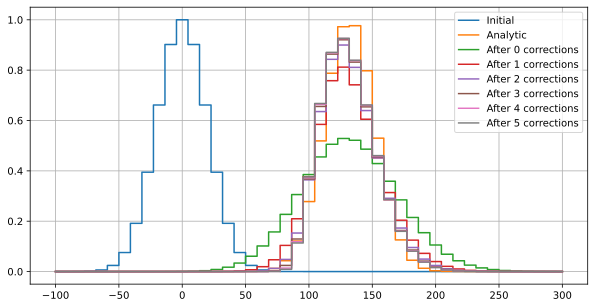

In [63]:
plot_data = {}
psi = psi_0(x)

plot_data["Initial"] = psi
plot_data["Analytic"] = psi_0(x - u * t_max)

for i in range(MAX_NUM_OF_CORRECTIONS + 1):
    plot_data[f"After {i} corrections"] = solve_mpdata(nt=nt, C=np.full(nx - 1, u * dt / dx), psi=psi.copy(), n_iters=i)

plot(x, **plot_data)

#### **Error measure**

In [64]:
def compute_error(numerical: np.ndarray, analytical: np.ndarray) -> float:
    """L2 error between numerical and analytical solutions."""
    return np.linalg.norm(numerical - analytical) / np.linalg.norm(analytical)


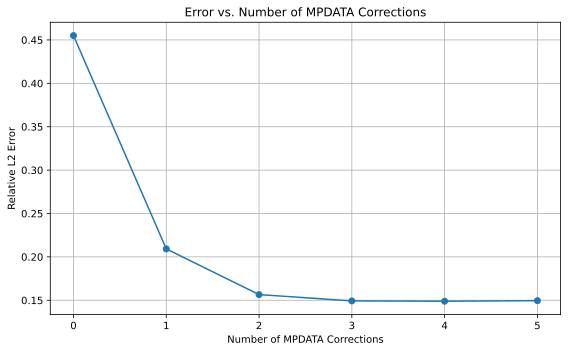

In [65]:
analytic = psi_0(x - u * t_max)

errors = []
correction_counts = []

for i in range(MAX_NUM_OF_CORRECTIONS + 1):
    numerical = plot_data[f"After {i} corrections"]
    err = compute_error(numerical, analytic)
    errors.append(err)
    correction_counts.append(i)

plt.figure(figsize=(8, 5))
plt.plot(correction_counts, errors, marker='o')
plt.xlabel("Number of MPDATA Corrections")
plt.ylabel("Relative L2 Error")
plt.title("Error vs. Number of MPDATA Corrections")
plt.grid(True)
plt.tight_layout()
plt.show()


## **Conclusions**

* MPDATA is clearly effective at reducing numerical error — even just one or two corrective iterations provide a major accuracy boost.

* More than 2–3 corrections yield only marginal gains. This suggests that in most practical scenarios, 2 corrections strike a good balance between accuracy and computational cost.

* The error plateau after a few corrective iterations reflects the fact that standard MPDATA reaches its designed second-order accuracy relatively quickly. Additional corrections do not increase the formal order of accuracy but only refine the existing approximation. To further reduce error, we can for example refine the grid resolution.